In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

C:\Users\nikit\PycharmProjects\recsys-itmo-spring-2023\venv\lib\site-packages\lightfm\_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


In [2]:
# DATA_DIR = "/Users/darya.nikanorova/Desktop/"
DATA_DIR = "../botify/data/"

In [3]:
data = pd.read_json(DATA_DIR + "input.json", lines=True).drop_duplicates(subset=["user", "track"])
data

,message,timestamp,user,track,time,latency,recommendation,experiments
0,next,2023-03-21 19:56:21.970,8811,3305,0.00,0.001737,18969.0,{}
1,next,2023-03-21 19:56:21.976,6588,4500,1.00,0.000979,692.0,{}
2,next,2023-03-21 19:56:21.981,6931,20667,1.00,0.000839,10713.0,{}
3,next,2023-03-21 19:56:21.985,8811,18969,0.97,0.001256,44576.0,{}
4,next,2023-03-21 19:56:21.988,6588,692,0.91,0.001389,27873.0,{}
...,...,...,...,...,...,...,...,...
569864,next,2023-03-21 20:42:03.026,943,8838,1.00,0.000809,29014.0,{}
569865,next,2023-03-21 20:42:03.151,943,29014,0.00,0.000724,49344.0,{}
569866,next,2023-03-21 20:42:03.158,943,49344,0.27,0.000720,10190.0,{}
569867,next,2023-03-21 20:42:03.165,943,10190,0.17,0.000891,25734.0,{}


In [4]:
positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7

In [5]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

In [6]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

## Train LightFM

In [7]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(44144, 15787)

In [8]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [9]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [10]:
def fit_model(
    epochs=1, 
    at=10, 
    loss="warp", 
    no_components=30, 
    learning_rate=0.01, 
    max_sampled=10, 
    user_alpha=0.0, 
    item_alpha=0.0, 
    threads=30,
    verbose=False,
    patience=3,
    epsilon=1e-6
):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    for epoch in range(epochs):
        # print("Started for cycle")
        model = model.fit_partial(train_interactions, num_threads=threads)
        # print("model.fit_partial finished")
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        # print("precision_at_k finished")
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
        
        if epoch > patience and all([precisions_at[-j] - precisions_at[-patience-1] < epsilon for j in range(1, patience + 1)]):
            if verbose:
                print("Early stopiing!")
            break
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]


In [11]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30)
# best_params = study.best_params

best_params = {
    'loss': 'warp',
    'no_components': 50,
    'learning_rate': 0.01,
    'max_sampled': 50,
    'user_alpha': 0.0,
    'item_alpha': 0.0001
}

In [12]:
print("Hello here")
model, precisions_at = fit_model(
    epochs=200,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

Hello here
0:	0.010176565498113632 +/- 0.0008862801910720326
1:	0.010337079875171185 +/- 0.0008973519219858838
2:	0.010770466178655624 +/- 0.0009176959477079747
3:	0.011508828960359097 +/- 0.0009638640831998858
4:	0.01216693501919508 +/- 0.001018443278144122
5:	0.013162118382751942 +/- 0.001068855703578536
6:	0.014189406298100948 +/- 0.0011276674401419454
7:	0.015409309417009354 +/- 0.0011806335070371557
8:	0.016404494643211365 +/- 0.0012162657091642443
9:	0.017062600702047348 +/- 0.001242547355998549
10:	0.01772070676088333 +/- 0.0012727490575527491
11:	0.018202247098088264 +/- 0.001291749889142952
12:	0.018731942400336266 +/- 0.0013088078995790293
13:	0.019020866602659225 +/- 0.001319806272851931
14:	0.019197432324290276 +/- 0.0013238488986616849
15:	0.01950240693986416 +/- 0.0013289415655589772
16:	0.020016049966216087 +/- 0.0013390909143317091
17:	0.02044943906366825 +/- 0.0013457550813607171
18:	0.02078651636838913 +/- 0.001353215544194635
19:	0.020995182916522026 +/- 0.0013603543

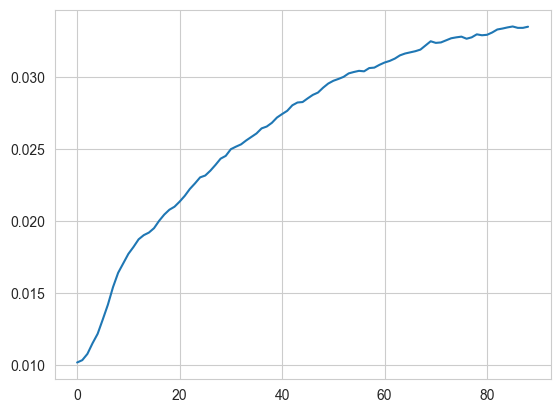

In [13]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [14]:
biases, embeddings = model.get_item_representations()

In [15]:
model.item_biases *= 0.0

In [16]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [17]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [18]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [19]:
k = 20
max_tracks_from_same_artist = 5

with open(DATA_DIR + f"recommendations_{k}_{max_tracks_from_same_artist}.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        j = track["dataset_index"]
        
        recommendations = []
        if pd.notna(j):
            embedding = embeddings[int(j)]
            neighbours = np.argsort(-np.dot(embeddings, embedding))
            
            artists = defaultdict(int)
            for neighbour in neighbours:
                recommended_track = dataset_tracks[dataset_tracks["dataset_index"] == neighbour].iloc[0]
                
                recommendation = int(recommended_track["track"])
                if recommendation == track["track"]:
                    continue
                
                artist = recommended_track["artist"]
                if artists[artist] >= max_tracks_from_same_artist:
                    continue
                
                recommendations.append(recommendation)
                artists[artist] += 1

                if len(recommendations) == k:
                    break
         
        track_with_recommendations = dict(track)
        track_with_recommendations["recommendations"] = recommendations
        
        rf.write(json.dumps(track_with_recommendations) + "\n")

50000it [00:37, 1316.13it/s]


## How many unique artist per recommendation list?

In [20]:
dataset_track_artists = dict(zip(
    dataset_tracks["track"].values.tolist(),
    dataset_tracks["artist"].values.tolist(),
))

In [21]:
recs = pd.read_json(DATA_DIR + f"recommendations_{k}_{max_tracks_from_same_artist}.json", lines=True)
recs = recs[recs["dataset_index"].notnull()]

sample = recs.sample(frac=0.1).iloc[0]

print(sample["title"], "by" , sample["artist"], "\n===")
print("\n".join([dataset_track_artists[track] for track in sample["recommendations"]]))

I Dont Want To See You by Camera Obscura 
===
Erin McKeown
Soltero
Soltero
Soltero
Emmy The Great
Soltero
Tiny Vipers
the bird and the bee
Soltero
the bird and the bee
the bird and the bee
the bird and the bee
Cibo Matto
the bird and the bee
The Generationals
Belle & Sebastian
Blood Red Throne
Air France
Frightened Rabbit
Frightened Rabbit


In [22]:
def count_artists(tracks):
    return len(
        set([dataset_track_artists[track] for track in tracks])
    )


artist_counts = recs["recommendations"].map(count_artists)
artist_counts.value_counts()

16    636
17    596
18    590
15    525
19    523
14    364
20    364
13    222
12    169
11     91
10     47
9      15
8       3
Name: recommendations, dtype: int64